In [1]:
from models import custom_RF as cm
from load_dataset import custom_lakedepth as ld
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 7]
from pprint import pprint
import numpy as np

In [2]:
lake_depth_data = ld.LakeDepth(random_state = 42)
"""
corr = lake_depth_data.covariates.corr()
cols = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >=0.9:
            if cols[j]:
                cols[j] = False
selected_cols = lake_depth_data.covariates.columns[cols]
lake_depth_data.covariates = lake_depth_data.covariates[selected_cols]
"""
# Only take first 6 bands
adjusted_columns_idx = lake_depth_data.covariates.columns[:6]
lake_depth_data.covariates = lake_depth_data.covariates[adjusted_columns_idx]
covariates_train, covariates_test, labels_train, labels_test = lake_depth_data.split(0.20)

# Make sure we did it right
lake_depth_data.covariates.head(5)

 - from DATA: reading csv into GPU memory
 - from DATA: done reading csv into GPU memory
 - from DATA: dropped column: FID
 - from DATA: dropped column: Date


,b1_LC8_075,b2_LC8_075,b3_LC8_075,b4_LC8_075,b5_LC8_075,b6_LC8_075
0,164.0,271.0,199.0,42.0,27.0,16.0
1,165.0,272.0,196.0,44.0,29.0,16.0
2,154.0,260.0,193.0,40.0,32.0,19.0
3,156.0,250.0,195.0,48.0,40.0,26.0
4,117.0,164.0,78.0,38.0,23.0,17.0


In [3]:
# Params for our fancy GPU-based RF model
hyperparameters = {'N_ESTIMATORS' : 1052,
					   'SPLIT_ALGO' : 1,
					   'SPLIT_CRITERION' : 2,
					   'BOOTSTRAP' : False,
					   'BOOTSTRAP_FEATURES' : False,
					   'ROWS_SAMPLE' : 1.0,
					   'MAX_DEPTH' : 50,
					   'MAX_LEAVES' : -1,
					   'MAX_FEATURES' : 'sqrt',
					   'N_BINS' : 16,
					   'MIN_ROWS_PER_NODE' : 2,
					   'MIN_IMPURITY_DECREASE' : 0.0,
					   'ACCURACY_METRIC' : 'mean_ae', # 'mse' #'r2' # 'median_aw' # 
					   'QUANTILEPT' : False,
					   'SEED' :  42,
					   'VERBOSE' : False
					   }
pprint(hyperparameters)

{'ACCURACY_METRIC': 'mean_ae',
 'BOOTSTRAP': False,
 'BOOTSTRAP_FEATURES': False,
 'MAX_DEPTH': 50,
 'MAX_FEATURES': 'sqrt',
 'MAX_LEAVES': -1,
 'MIN_IMPURITY_DECREASE': 0.0,
 'MIN_ROWS_PER_NODE': 2,
 'N_BINS': 16,
 'N_ESTIMATORS': 1052,
 'QUANTILEPT': False,
 'ROWS_SAMPLE': 1.0,
 'SEED': 42,
 'SPLIT_ALGO': 1,
 'SPLIT_CRITERION': 2,
 'VERBOSE': False}


In [4]:
import time
rf_model_bands_one_six = cm.cuRF(hyperparameters)
st = time.time()
rf_model_bands_one_six.train(covariates_train, labels_train)
et = time.time()
print("Time to train: ", et-st)

/att/gpfsfs/briskfs01/ppl/cssprad1/projects/rapids_rf_lake_depth/models/custom_RF.py:154: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams==1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  verbose=param['VERBOSE'])


Time to train:  5.417667865753174


In [5]:
predictions, _, _, _ = rf_model_bands_one_six.get_metrics(covariates_test, labels_test)

Scores ------
 MAE:  0.5622773
  r2:  0.6403507776927668
 MSE:  1.2313956


Variables: b6_LC8_075           Importance: -0.2883
Variables: b5_LC8_075           Importance: -0.31371
Variables: b2_LC8_075           Importance: -0.42452
Variables: b4_LC8_075           Importance: -0.56957
Variables: b1_LC8_075           Importance: -0.7263
Variables: b3_LC8_075           Importance: -0.89241


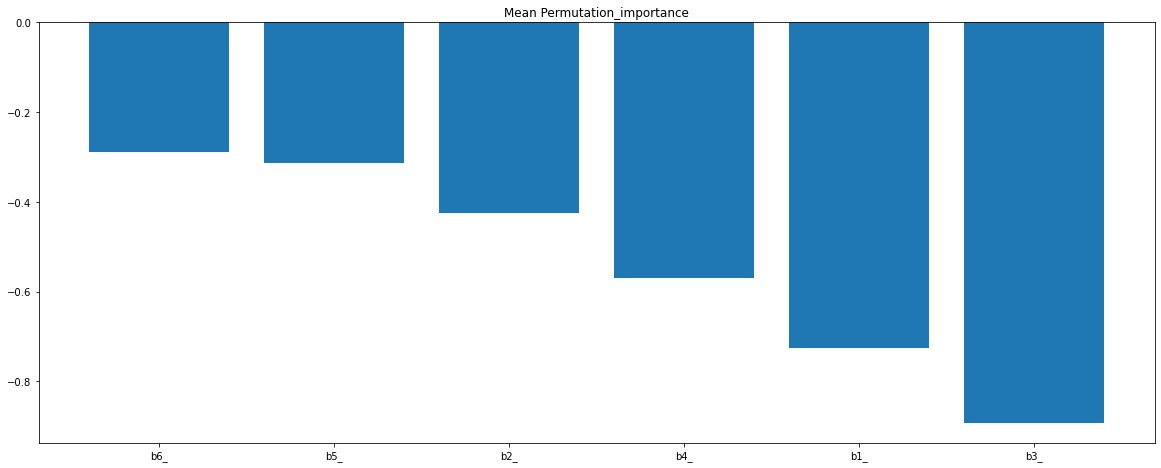

In [6]:
rf_model_bands_one_six.feature_importances(covariates_train, labels_train, show = False)

## Hard-code the permutation_importance to check for errors

In [7]:
from sklearn.inspection import permutation_importance
result = permutation_importance(rf_model_bands_one_six.model, 
                                covariates_train, 
                                labels_train, 
                                n_repeats=5, 
                                random_state=42)

Feature: 0, Score: -0.28817
Feature: 1, Score: -0.31362
Feature: 2, Score: -0.42631
Feature: 3, Score: -0.57035
Feature: 4, Score: -0.72450
Feature: 5, Score: -0.89107


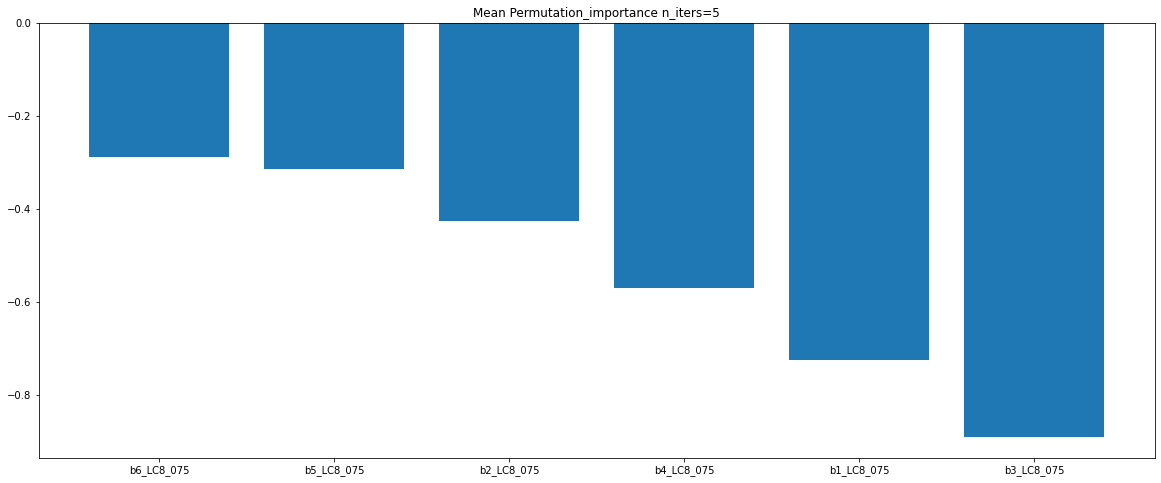

Importances_mean:  [-0.72450082 -0.4263059  -0.89106582 -0.57035173 -0.31362457 -0.28817413]
Importances_std:  [0.0063552  0.00523126 0.00860254 0.00465118 0.00245373 0.00469485]


In [8]:
import numpy as np
sorted_idx = result.importances_mean.argsort()
sorted_idx = np.flip(sorted_idx)
importance = result.importances_mean
for i, v in enumerate(importance[sorted_idx]):
    print('Feature: %0d, Score: %.5f' %(i, v))
plt.figure(figsize=(20, 8))
plt.bar([x for x in range(len(importance))], importance[sorted_idx])
plt.xticks(range(len(importance)), list(covariates_train.columns[sorted_idx]))
plt.title("Mean Permutation_importance n_iters=5")
plt.show()
print("Importances_mean: ",result.importances_mean)
print("Importances_std: ",result.importances_std)

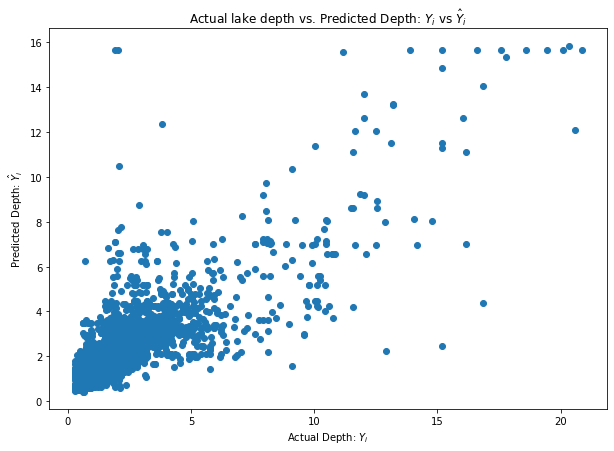

In [9]:
plt.scatter(labels_test.to_array(), predictions.to_array())
plt.xlabel("Actual Depth: $Y_i$")
plt.ylabel("Predicted Depth: $\hat{Y}_i$")
plt.title("Actual lake depth vs. Predicted Depth: $Y_i$ vs $\hat{Y}_i$")
plt.show()

### Random sampling to compare actual vs predicted values

In [10]:
# Lets look at a random sample of datapoints to see the actual vs predicted depths
import random
for i in range(20):
    random_data_point = random.randint(0, 4635)
    print('Data-point: {:5} Actual: {:20} Predicted: {:20}'.format(random_data_point, labels_test.to_array()[random_data_point],
                                               predictions.to_array()[random_data_point]))

Data-point:  2661 Actual:   2.0284299850463867 Predicted:   2.0822975635528564
Data-point:  4510 Actual:   2.2108500003814697 Predicted:    2.010662794113159
Data-point:  4343 Actual:    2.127500057220459 Predicted:   2.1197617053985596
Data-point:  1892 Actual:    1.719920039176941 Predicted:    1.785485863685608
Data-point:  3575 Actual:    2.078089952468872 Predicted:   1.5543180704116821
Data-point:   505 Actual:    1.559499979019165 Predicted:    2.097175121307373
Data-point:  2194 Actual:    1.555999994277954 Predicted:   1.4365489482879639
Data-point:  2799 Actual:   0.8007689714431763 Predicted:    2.117337942123413
Data-point:   223 Actual:   1.7426400184631348 Predicted:   1.7523741722106934
Data-point:  3724 Actual:    4.356249809265137 Predicted:    6.883606910705566
Data-point:  4028 Actual:   2.0078299045562744 Predicted:   1.7869693040847778
Data-point:  1812 Actual:   1.5579999685287476 Predicted:   1.3987534046173096
Data-point:   964 Actual:   1.4974199533462524 Predi